# Affects in Tweets - Twitter Sentiment Analysis

- André Rocha, FEUP, up201706462@fe.up.pt
- Tito Griné, FEUP, up201706732@fe.up.pt
- Vítor Ventuzelos, FEUP, up201706403@fe.up.pt

## Introduction
Twitter sentiment analysis has become a common method to monitor the public's opinion regarding a given matter (either their brand, their business, etc). It is known such an analysis has very noticeable differences towards other sentiment analysis challenges: Twitter's messages, usually called Tweets, has a very noisy nature. Starting off the fact that it only allows 140 characters, which leads to several abbreviations and irregular expressions, it is also a space where slang is very common. These cases lead to a very high level of data sparsity.

Having to face such an issue, it is common to resort to stopwords to reduce textual noise. Due to its irregular contractions and slang, using pre-compiled stopwords lists have a negative impact, due to their inabilities to keep to up to date with new terms and information. It has been shown though, that dynamically generated stopwords lists increase greatly accuracies (Saif et.al 2014).

It is also common for emojis to be used in tweets. It is common to remove them as a whole, as well as attribute a sentiment to it or express it by a single word.

There also very common recognizable noise patterns that are commonly removed from tweet such as: hashtags ('#'), URLs, and repeated letters. These usually tend to have a negative impact by themselves.

Due to the common use of slang, contractions and even misspelling, the substitution of these by their more *formal* versions is usually explored, once again to further reduce data sparsity.

All of these methods explained above, and some common approaches NLP problems such as lemmatization and stemming, will be explored. A simple baseline method using only a Tokenizer will be used to compare against the others. Furthermore, several different Classifiers will be explored, such as [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html), [Support Vector Machines](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm), [Multi-layer Perceptron Neural Network](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) and [1D Convolutional Neural Network](https://keras.io/examples/imdb_cnn/).

In [2]:
from datasets.process_dataset import process_dataset
data1 = process_dataset("datasets/trains.txt")
data2 = process_dataset("datasets/dev.txt")
data3 = process_dataset("datasets/test.txt")
data = data1 + data2 + data3

## Dataset Analysis
It was first made an analysis on the quality of the dataset of the SemEval2018 challenge. This was relevant to understand some problems that this would give us, such as the fact that the dataset is very small or that the class distribution is not particularly even.

### Class Distribution
It was first done a class distribution analysis, in order to perceive how balanced was our sample. It is clear to see the distribution was quite uneven between all of the classes, which created a new need: to test the use of oversampling, which will be discussed later. Something that also stands out is the fact the number of samples of this dataset is quite small, which led us to believe solutions based on Word Embeddings (such as our Convolutional Neural Network).

Such results perceived baseline results which would be much lower than expected, especially when it came to such a classification using such a small dataset. It was also considered to be considered the reduction of the number of labels. Most work seen in the area had indeed resorted mostly to binary classification (in positive or negative) or to tertiary classification (positive, negative or neutral).


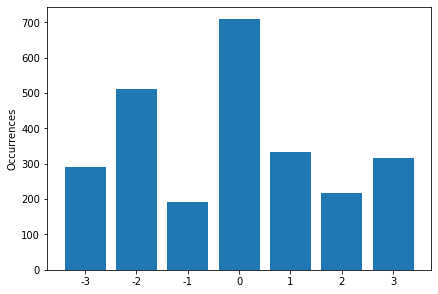

In [4]:
import numpy as np
import matplotlib.pyplot as plt

classes = {}
for t in data:
    classes[t.intensity] =  classes.get(t.intensity, 0) + 1

objects = sorted(classes.keys())
y_pos = np.arange(len(objects))
values = list(map(lambda key: classes[key], objects))

plt.bar(y_pos, values)
plt.xticks(y_pos, objects)
plt.ylabel('Occurrences')
plt.tight_layout(0.4)
plt.savefig('intensity_analysis.png')
plt.show()

### TF-IDF Distribution

It was then decided to assert the quality of the Tweets in the dataset. With the TF-IDF distribution, we are able to assert the amount of times words are repeated throughout the dataset. It is shown below this information using a Scatter Plot.

From the amount of words whose TF-IDF is near zero, it is clear that most words do not show up more than once in the whole dataset. This gave us the knowledge that most information would be removed from Tweets if we were to use the dynamic stopwords list generation method TF1, whose goal is to remove all words who only show up once in the whole dataset.


/home/andrefmrocha/Projects/Project_2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/andrefmrocha/Projects/Project_2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20114 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/andrefmrocha/Projects/Project_2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12501 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/andrefmrocha/Projects/Project_2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/andrefmrocha/Projects/Project_2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12525 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/andr

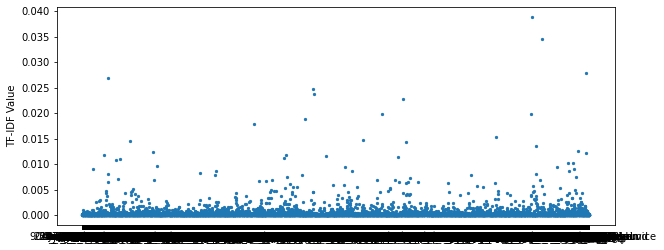

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = map(lambda x: x.tweet, data)

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(corpus)

tfidf_mean = tfidf_vectorizer_vectors.mean(axis=0).tolist()[0]

# get the first vector out (for the first document)

# place tf-idf values in a pandas data frame
plt.figure(figsize=(10,4))
plt.scatter(tfidf_vectorizer.get_feature_names(), tfidf_mean, s=5)
plt.ylabel('TF-IDF Value')
plt.savefig('tf_idf.png')
plt.show()

### Wordcloud
Even though a wordcloud does not represent any new information regarding what has been shown before, it is an interesting way to look at the words existing in the dataset. It also allowed us to understand how common it was to see the use of the ampersand, which made us understand that it was vital to remove some html references that were still in the dataset.


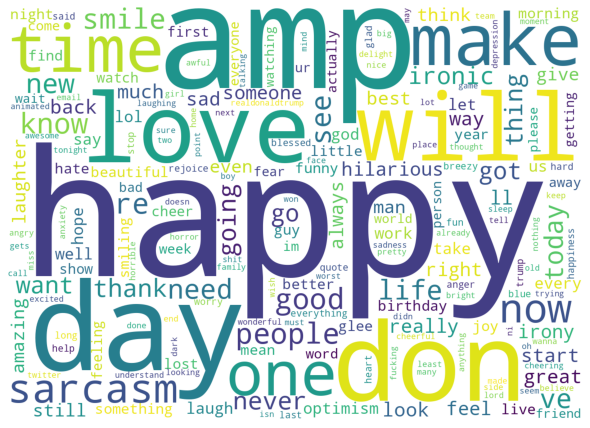

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

corpus = map(lambda x: x.tweet, data)
count_vectorizer = CountVectorizer()
count_vectorizer_vectors = count_vectorizer.fit_transform(corpus)
word_count = count_vectorizer_vectors.sum(axis=0).tolist()[0]

features = count_vectorizer.get_feature_names()
cloud_words = ""
for i in range(0, len(word_count)):
    for _ in range(0, word_count[i]):
        cloud_words += features[i] + " "

wordcloud = WordCloud(width=1280, height=920, background_color='white', stopwords=STOPWORDS, collocations=False).generate(cloud_words)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('wordcloud.png')
plt.show()

In [5]:
from pipelines.basic import basic_pipeline
from sklearn.metrics import classification_report
from datasets.process_dataset import get_dataset
from sklearn.model_selection import train_test_split


x1, y1 = get_dataset(data)
x2, y2 = get_dataset(process_dataset("datasets/dev.txt"))
x = x1 + x2
y = y1 + y1

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = basic_pipeline(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

Using TensorFlow backend.


ValueError: Found input variables with inconsistent numbers of samples: [3016, 5134]

## References
1. A. Kunwar, [Twitter Sentiment Analysis GUI](https://github.com/akbloodadarsh/Twitter-Sentimental-Analysis)
2. C. Alcantara and J. Cassiano, [Social Network Sentiment Analysis](https://github.com/cassio-all/sentimental_analysis_twitter)
3. C. Baziotis, [SemEval 2018](https://github.com/cbaziotis/ntua-slp-semeval2018)
4. S. Doshi, [Twitter Sentiment Analysis using fastText](https://towardsdatascience.com/twitter-sentiment-analysis-using-fasttext-9ccd04465597)
5. Hassan S., Miriam F., Yulan H. and Harith, A,  ["On Stopwords, Filtering and Data Sparsity for Sentiment Analysis of Twitter"](http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf), 2014
6. Z. Jianqiang and G. Xiaolin, ["Comparison Research on Text Pre-processing Methods on Twitter Sentiment Analysis"](https://ieeexplore.ieee.org/abstract/document/7862202), 2017
7. A. Severyn and A. Moschitti, ["Twitter Sentiment Analysis with Deep Convolutional Neural Networks"](https://dl.acm.org/doi/abs/10.1145/2766462.2767830), 2015
